Created on Tuesday 5 January 2021

**Group 5 - Classification**  
**Clustering chart v0**

@authors : Damien Izard, Nour Elhouda Kired, Paule Cadrelle Massag, Jessicka Mucy-Clavier, Gabriel nathir Kassem Rojas

The dfFixer code compute the df_final_clean datas with the ones in Data.json in order to get 7533 lines of unique articles with their titles, tags and content.

Then, the clusterizer gets the tf-idf on our dataset and create the train and test set based on the article which have one or more tags and the ones which don't have any.

With the train set we compute a k-means model with 9 clusters. We've studied the inertia with various value of k and choose the best one. Our clustering done we compute a new tf-idf on the content of the articles contained in the train set and train a new k means model on it. Finally, we predict labels on the test set and concat all datas and predictions in the prediction dataframe.

# Import libraries

In [ ]:
import os
import nltk
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Execute this block of code only if you wish to avoid warnings in the output.
warnings.filterwarnings('ignore')
# Stopword
nltk.download('stopwords')
# Updating the nltk stopwords package
%load_ext google.colab.data_table

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

In [ ]:
# Import BoW data of group 3
bow: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json")
# Import data with the articles
dataframe: pd.DataFrame = dfFixer("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data.json",
                                  "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/df_final_clean.json")

# Functions

In [ ]:
# Find a label for each cluster (here 9 clusters)
def clusterizer(path: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        path: Contains the path to our dataframe

    Out:
        df_labels: A dataframe containing a column that has the article's label
    """
    # Step 1: load the dataframe into variable df
    df: pd.DataFrame = pd.read_json(path)

    # Step 2: creates both the train set and the test set
    # Replace all the empty tags of each article with NaN value
    df.art_tag = df.art_tag.apply(lambda y: np.nan if len(y) == 0 else y)

    # Copies our dataframe as our initial train set, while dropping all the articles with no tags
    train_set: pd.DataFrame = df.copy()
    train_set.dropna(subset=['art_tag'], inplace=True)

    # Creates our test set with the articles that have no tags
    mask: pd.Series = df['art_id'].isin(train_set['art_id'])
    test_set: pd.DataFrame = df[~mask]

    # Step 3: gives all the articles in the train set labels
    stopwords_fr: list = stopwords.words('french')
    # Vectorizes all the tags in the train set while cleaning it from stop words
    vectorizer: TfidfVectorizer = TfidfVectorizer(
        tokenizer=lambda x: x, preprocessor=lambda x: x, stop_words=stopwords_fr)
    X = vectorizer.fit_transform(train_set['art_tag'])
    terms: list = vectorizer.get_feature_names()

    # Creates 9 clusters, each representing a label, in order to group up the tags obtained after the vectorization
    nb_clusters = 9
    kmeans: KMeans = KMeans(n_clusters=nb_clusters)

    # Creates a list containing a label for each article using the information obtained from the clusters
    ymean: np.ndarray = kmeans.fit_predict(X)

    # Stores in df the dataframe containing the articles from the train set with labels
    df_labeled: pd.DataFrame = pd.DataFrame({'art_id': train_set['art_id'],
                                             'art_content_prepd': train_set['art_content_prepd'],
                                             'art_title': train_set['art_title'],
                                             'art_tag': train_set['art_tag'],
                                             'labels': ymean})

    # Step 4: vectorizing the data in the train set to use in the test set
    ytrain: pd.Series = df_labeled['labels']
    # Redefining the vectorizer to use the content of the train_set instead
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_set['art_content_prepd'])
    vocabulary: dict = vectorizer.vocabulary_

    # Encode document
    xtrain: np.ndarray = vectorizer.transform(
        train_set['art_content_prepd']).toarray()
    xtest: np.ndarray = vectorizer.transform(
        test_set['art_content_prepd']).toarray()

    # Train our model on train_set datas
    list_classes: np.ndarray = np.arange(0, nb_clusters)
    model = KMeans(n_clusters=nb_clusters)
    clf = model.fit(xtrain, ytrain)

    # Predict labels for test_set datas
    ypred: np.ndarray = clf.predict(xtest)

    df_train: pd.DataFrame = pd.DataFrame({'art_id': train_set['art_id'],
                                           'labels': ymean})
    df_test: pd.DataFrame = pd.DataFrame({'art_id'	: test_set['art_id'],
                                          'labels': ypred})

    prediction_concat = pd.concat([df_train, df_test], ignore_index=True)
    prediction_sorted = prediction_concat.sort_values(['art_id', 'labels'])
    prediction_sorted.to_csv('pred_v0_clustering.csv')

    # Save our prediction in a csv file
    !cp pred_v0_clustering.csv "drive/My Drive/G5 Inter-Promo 2021/Données/Output/Clustering"

    return prediction_sorted

In [ ]:
# Cleans data
def dfFixer(pathData: str, pathDataClean: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        pathData: Contains the path to our Data dataframe
        pathDataClean: Contains the path to the newer version of the dataframe

    Out:
        df_clean: Contains the cleaner dataframe with columns containing the tags and the article's title
    """
    # Step 1: load the dataframes into data and dataClean
    data: pd.DataFrame = pd.read_json(pathData)
    dataClean: pd.DataFrame = pd.read_json(pathDataClean)

    # Step 2: prepares empty lists for tags and article titles
    titles: list = ["empty"]*7533
    tags: list = [[]]*7533
    index: int = 0

    # Go through each article in dataClean and search for it's title and tags in Data
    for i in dataClean['art_id']:
        # In case of tags, we will turn the tags into lists of tags
        titles[index] = data.loc[data['art_id'] == i]['art_title'].values[0]
        test_list: str = data.loc[data['art_id'] == i]['art_tag'].values[0]
        # Transform "None" into empty lists
        if test_list == None:
            tags[index] = []
        # Detect lists and transform them from str into lists
        elif test_list[0] == '[':
            tags[index] = eval(test_list)
        # Detects "not Found" strings and replaces them with an empty list
        else:
            if "Not Found" == test_list:
                tags[index] = []
            # Transforms any tags that are just an str into a list of 1 tag
            else:
                tags[index] = [test_list]

        index = index+1

    # Transforms a list with empty string into an empty list
    for i in range(len(tags)):
        if tags[i] == ['']:
            tags[i] = []
        # Deletes all the hash symbols from the tags
        for j in range(len(tags[i])):
            if tags[i][j][0] == '#':
                tags[i][j] = tags[i][j][1:]

    # Step 3: prepares the output
    df_clean: pd.DataFrame = pd.DataFrame({'art_id': dataClean['art_id'],
                                           'art_content_prepd': dataClean['art_content_prepd'],
                                           'art_title': titles,
                                           'art_tag': tags})

    return df_clean

In [ ]:
# Displays the wordcloud for each cluster
def wordcloud_bow(bow: pd.DataFrame, prediction: list):
    """Documentation
    Parameters:
        bow: Bag of Word
        prediction: The prediction that will be used to make distinction bewteen the differents class

    Out:
        N_cluster wordclouds
    """
    df: pd.DataFrame = bow.copy()
    df["pred"] = prediction

    # Distinction bewteen the differents class
    for i in set(prediction):
        wordcloud: WordCloud = WordCloud(
            relative_scaling=1.0,
        ).generate_from_frequencies(
            dict(bow.loc[df[df["pred"] == i].index].sum(axis=0))
        )
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title("Cluster " + str(i))
        plt.show()

In [ ]:
# Drop no representative words
def whitelist_content(pd: pd.DataFrame, list_whitelist: list) -> pd.DataFrame:
    """Documentation
    Parameters:
        pd: Bag of word where we wish to drop columns of unwanted words
        list_whitelist: List of unwanted words

    Out:
        Bag of word without unwanted words
    """

    return pd.drop(list_whitelist, axis=1)

In [ ]:
# Displays data on the main components of the PCA
def graph_3d(data: pd.DataFrame, prediction: pd.Series, name: dict = None, axes: tuple = (0, 1, 2), opacity: dict = None):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        name: Clusters names (ex: {prediction_value: name})
        axes: Axes of pca to display points
        opacity: The transparency of the points on the graph (ex: {prediction_value: opacity_value})

    Out:
        3D graph of data on the main components of the PCA
    """

    if opacity is None:
        opacity: dict = {val: 1 for val in set(prediction)}
    if name is None:
        name: dict = {val: str(val) for val in set(prediction)}

    # Normalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=10)
    X: np.ndarray = pca.fit_transform(X)

    # Predict
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction

    data: list = []
    # Create chart
    for val in set(prediction):
        data_semi_plot: pd.DataFrame = data_plot[data_plot["prediction"] == val]
        data.append(go.Scatter3d(x=data_semi_plot[axes[0]], y=data_semi_plot[axes[1]], z=data_semi_plot[axes[2]],
                                 name=name[val], mode='markers', marker=dict(size=6), opacity=opacity[val]))

    fig: go.Figure = go.Figure(data)
    fig.show()

# Optimal number of cluster

Calculating the silhouette score, display graph and chooses the optimal number of clusters.

In [ ]:
# Calculating the silhouette score
score: list = []
for i in tqdm(range(2, 21)):
    kmeans: KMeans = KMeans(i, random_state=0).fit(
        bow.drop(["art_id", "art_content_clean_without_lem"], axis=1))
    kmeans_pred: np.ndarray = kmeans.labels_
    score.append(silhouette_score(
        bow.drop(["art_id", "art_content_clean_without_lem"], axis=1), kmeans_pred))

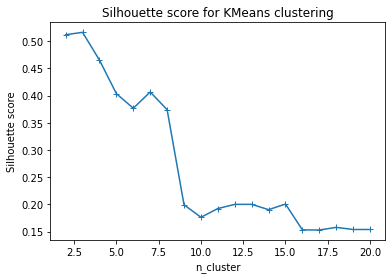

In [ ]:
# Graphic of the silouhette score for kMeans clustering
plt.plot(range(2, 21), score, '-+')
plt.title("Silhouette score for KMeans clustering")
plt.xlabel("n_cluster")
plt.ylabel("Silhouette score")
plt.show()

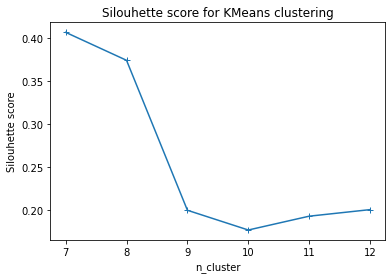

In [ ]:
# Graphic of the silouhette score for kMeans clustering
window: tuple = (7, 13)
plt.plot(range(window[0], window[1]),
         score[window[0] - 2: window[1] - 2], '-+')
plt.title("Silouhette score for KMeans clustering")
plt.xlabel("n_cluster")
plt.ylabel("Silouhette score")
plt.show()

The optimal number of clusters we found is 9.

# Prediction

In [ ]:
# The path to where we wish to export our new dataframe.
path_result: str = "/content/drive/MyDrive/Colab Notebooks/test.json"

# Checks if file exist
if os.path.exists(path_result):
    os.remove(path_result)
# Exporting the dataframe to the path set in path_result in .json format
dataframe.to_json(path_result)

# Prediction des cluster
prediction: pd.DataFrame = clusterizer(path_result)
prediction

,art_id,labels
5256,1,4
5257,2,4
5258,25,2
5259,27,4
5260,28,4
...,...,...
7528,12256,4
7529,12257,4
7530,12258,4
7531,12259,4


In [ ]:
# Number of document per cluster
pd.Series(prediction["labels"]).value_counts()

4    2346
0    2332
1     618
5     562
3     542
6     499
2     239
7     207
8     188
Name: labels, dtype: int64

# Visualization

Displays a wordcloud of each cluster, excluding the words in the whitelist, and plot a 3D graph to show the distribution of articles in each cluster.

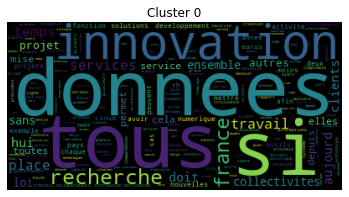

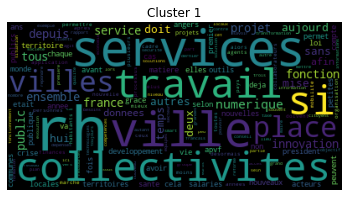

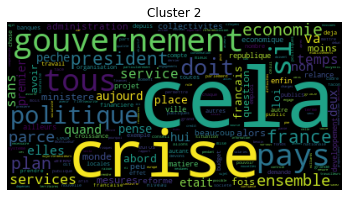

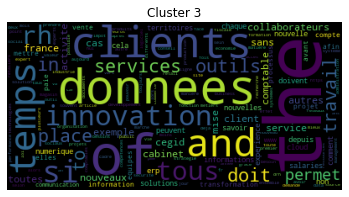

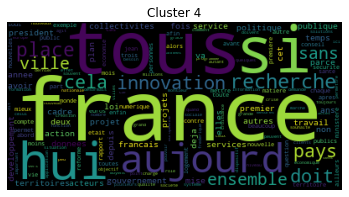

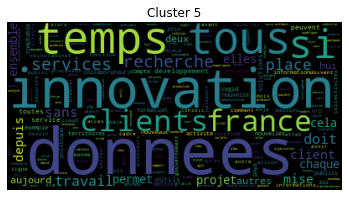

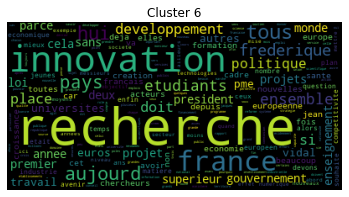

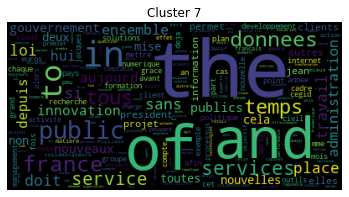

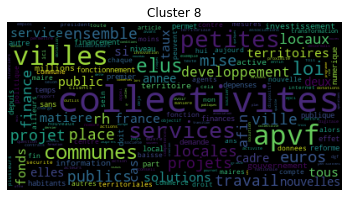

In [ ]:
# List word stop
whitelist: list = ["plus", "tout", "cette", "ca", "etre", "dire", "faut", "fait", "faire", "donc", "entreprise", "gestion", "entreprises", "aussi",
                   "meme", "bien", "ete", "comme", "etat", "ministre", "tres", "encore", "peut", "dont", "egalement", "notamment", "ainsi", "leurs", "entre"]
# Drop no representative words
whitelisted_bow: pd.DataFrame = whitelist_content(
    bow.drop(["art_id", "art_content_clean_without_lem"], axis=1), whitelist)
# Visualization of word cloud
wordcloud_bow(whitelisted_bow, prediction["labels"])

3D Representation

In [ ]:
graph_3d(bow.drop(["art_id", "art_content_clean_without_lem"], axis=1),
         prediction["labels"], opacity={i: 0.5 for i in set(prediction["labels"])})